In [1]:
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
case_loc=r"us-counties.csv"
sdi_loc=r"SDI.xlsx"
sdi = pd.read_excel(sdi_loc)

In [3]:
case = pd.read_csv(case_loc)
case_columns=["date","county","state","fips","cases",'deaths']
case=case[case_columns]
sdi_columns=["county","sdi_score"]

In [4]:
## missing fips in file
case["fips"][case["county"]=="Unknown"]=0
case["fips"][case["county"]=="New York City"]=36061
case["fips"][case["county"]=="Kansas City"]=2000
case["fips"].astype(int)
fips_state=case[["fips","state"]].drop_duplicates()
total_case=case.groupby(by=["date","state"])["cases"].sum().reset_index()
total_death=case.groupby(by=["date","state"])["deaths"].sum().reset_index()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
def find_median(th0,th1):
    total_case_selected1 = total_case[total_case["cases"] < th0]
    total_case_selected2 = total_case[total_case["cases"] < th1]  # get data within threshold
    total_case_selected1 = total_case_selected1.groupby(by=["state"])[
        "date"].max().reset_index() #get the primary date
    total_case_selected2= total_case_selected2.groupby(by=["state"])[
        "date"].max().reset_index()  # get the latest date
    county_list1 = pd.merge(total_case_selected1, case, left_on=["date", "state"], right_on=["date", "state"],
                           how="left")  # get the county list
    county_list2 = pd.merge(total_case_selected2, case, left_on=["date", "state"], right_on=["date", "state"],
                            how="left")  # get the county list
    county_compare=pd.merge(county_list1,county_list2,left_on=["fips"],right_on=["fips"],how="left")
    county_compare=county_compare[county_compare["cases_x"]==county_compare["cases_y"]] #compare and find the case where increment for each state
    fips_list = list(set(county_list2["fips"].tolist()) - set(county_compare["fips"].tolist())) #remove the case from the list and only get fips
    county_list=pd.DataFrame(fips_list,columns=["fips"])#convert to df (only fips)
    final_table = pd.merge(county_list, fips_state, left_on=["fips"], right_on=["fips"],
                           how="left") #add state info
    final_table = pd.merge(final_table, edu, left_on=["fips"], right_on=["FIPS Code"], how="left")
    final_table = pd.merge(final_table, pov, left_on=["fips"], right_on=["FIPStxt"],
                           how="left")  # merge two edu and pov tables in the final result
    final_table = pd.merge(final_table, sdi, left_on=["fips"], right_on=["county"],
                           how="left")
    edu_median = final_table.groupby(by=["state"])[
        "Area name", "Edu"].median().reset_index()
    poverty_median = final_table.groupby(by=["state"])['PCTPOVALL_2018'].median().reset_index() # get the median
    sdi_median = final_table.groupby(by=["state"])['sdi_score'].median().reset_index()
    return(poverty_median,edu_median,sdi_median)




In [6]:
maxcase = case.groupby(by=["date","state"])["cases"].sum().max()

In [7]:
threshold0=0
threshold1=10
case_x =[threshold1] ## linear regression x variable
sdi_result = sdi_result.rename(columns={'sdi_score': 'sdi'+str(threshold0)+'-'+str(threshold1)})

In [8]:
threshold0=10
threshold1=100
case_x.append(threshold1)
sdi_result2 = sdi_result2.rename(columns={'sdi_score': 'sdi'+str(threshold0)+'-'+str(threshold1)})
sdi_result=sdi_result.merge(sdi_result2, on =['state'],how="left")

In [9]:
## threshold0=100
## threshold1=1000

In [10]:
for i in range(1,10):
    threshold0= i*100
    threshold1= threshold0 +100
    case_x.append(threshold1)
    result_sdi= result_sdi.rename(columns={'sdi_score': 'sdi-'+str(threshold0)+'-'+str(threshold1)})
    sdi_result=sdi_result.merge(result_sdi, on =['state'],how="left")

In [11]:
for i in range(1,len(sdi_result.columns)-1):
    sdi_result.iloc[:,i].fillna(sdi_result.iloc[:,i+1],inplace =True)
for i in range(1,len(sdi_result.columns)-1):
    sdi_result.iloc[:,i].fillna(sdi_result.iloc[:,i+1],inplace =True)

In [14]:
sdi_result.to_csv(r"sdi_result_case.csv",index=False)

## plot of SDI

In [15]:
mean_case = sdi_result.mean(axis = 0)
median_case = sdi_result.median(axis = 0)
stat = pd.concat([mean_case,median_case],axis=1).reset_index(drop=True)
stat.rename(columns={'0': 'mean','1':'median'},inplace = True)

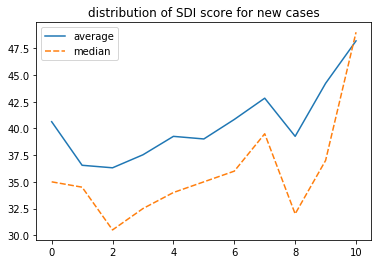

In [16]:
import seaborn as sns
fig, ax = plt.subplots()
g = sns.lineplot(data=stat)
legend = ax.legend()
legend.texts[0].set_text("average")
legend.texts[1].set_text("median")
g.set_title('distribution of SDI score for new cases')
g.get_figure().savefig("sdi_cases.png")

## number of deaths

In [17]:
def find_median_for_death(th0,th1):
    total_death_selected1 = total_death[total_death["deaths"] < th0]
    total_death_selected2 = total_death[total_death["deaths"] < th1]  # get data within threshold
    total_death_selected1 = total_death_selected1.groupby(by=["state"])[
        "date"].max().reset_index() #get the primary date
    total_death_selected2= total_death_selected2.groupby(by=["state"])[
        "date"].max().reset_index()  # get the latest date
    county_list1 = pd.merge(total_death_selected1, case, left_on=["date", "state"], right_on=["date", "state"],
                           how="left")  # get the county list
    county_list2 = pd.merge(total_death_selected2, case, left_on=["date", "state"], right_on=["date", "state"],
                            how="left")  # get the county list
    county_compare=pd.merge(county_list1,county_list2,left_on=["fips"],right_on=["fips"],how="left")
    county_compare=county_compare[county_compare["cases_x"]==county_compare["cases_y"]] #compare and find the case where increment for each state
    fips_list = list(set(county_list2["fips"].tolist()) - set(county_compare["fips"].tolist())) #remove the case from the list and only get fips
    county_list=pd.DataFrame(fips_list,columns=["fips"])#convert to df (only fips)
    final_table = pd.merge(county_list, fips_state, left_on=["fips"], right_on=["fips"],
                           how="left") #add state info
    final_table = pd.merge(final_table, edu, left_on=["fips"], right_on=["FIPS Code"], how="left")
    final_table = pd.merge(final_table, pov, left_on=["fips"], right_on=["FIPStxt"],
                           how="left")  # merge two edu and pov tables in the final result
    final_table = pd.merge(final_table, sdi, left_on=["fips"], right_on=["county"],
                           how="left")
     # get the median
    sdi_median = final_table.groupby(by=["state"])['sdi_score'].median().reset_index()
    return(sdi_median)

In [18]:
threshold0=0
threshold1=10
death_x =[threshold1]
sdi_result_death = sdi_result_death.rename(columns={'sdi_score': 'sdi'+str(threshold0)+'-'+str(threshold1)})

for i in range(1,10):
    threshold0= i*10
    threshold1= threshold0 +10
    death_x.append(threshold1)
    result_sdi= result_sdi.rename(columns={'sdi_score': 'sdi-'+str(threshold0)+'-'+str(threshold1)})
    sdi_result_death=sdi_result_death.merge(result_sdi, on =['state'],how="left")

In [19]:
for i in range(1,len(sdi_result_death.columns)-1):
    sdi_result_death.iloc[:,i].fillna(sdi_result_death.iloc[:,i+1],inplace =True)
    
for i in range(1,len(sdi_result_death.columns)-1):
    sdi_result_death.iloc[:,i].fillna(sdi_result_death.iloc[:,i+1],inplace =True)

In [20]:
sdi_result_death.to_csv(r"sdi_result_death.csv",index=False)

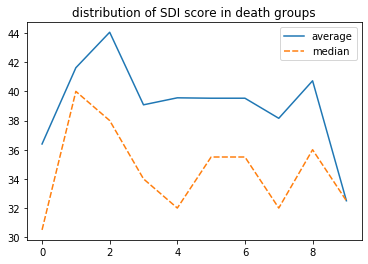

In [21]:
mean_death = sdi_result_death.mean(axis = 0)
median_death = sdi_result_death.median(axis = 0)
stat = pd.concat([mean_death,median_death],axis=1).reset_index(drop=True)
stat.rename(columns={'0': 'mean','1':'median'},inplace = True)
import seaborn as sns
fig, ax = plt.subplots()
g = sns.lineplot(data=stat)
legend = ax.legend()
legend.texts[0].set_text("average")
legend.texts[1].set_text("median")
g.set_title('distribution of SDI score in death groups')
g.get_figure().savefig("sdi_death.png")

In [30]:
death_x

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

## Trend  Analysis

In [22]:
import pymannkendall as mk


In [23]:
mk.original_test(mean_death[:-1]).p


1.0

In [24]:
mk.original_test(median_death[:-1]).p

1.0

In [25]:
mk.original_test(mean_case).p

0.008123423304273514

In [26]:
mk.original_test(median_case).p

0.0724947934869995

## Regression

In [31]:
df = pd.DataFrame({ 'x' : death_x[:-1],
    'mean' : mean_death[:-1],'median': median_death[:-1]})
df.head()

,x,mean,median
sdi0-10,10,36.392157,30.5
sdi-10-20,20,41.621622,40.0
sdi-20-30,30,44.055556,38.0
sdi-30-40,40,39.078947,34.0
sdi-40-50,50,39.558824,32.0


## SDI MEAN FOR DEATH

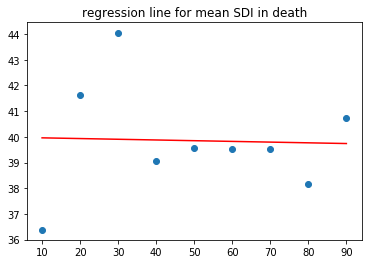

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.141
Method:                 Least Squares   F-statistic:                  0.008618
Date:                Sat, 25 Apr 2020   Prob (F-statistic):              0.929
Time:                        19:10:51   Log-Likelihood:                -19.164
No. Observations:                   9   AIC:                             42.33
Df Residuals:                       7   BIC:                             42.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9883      1.676     23.856      0.0

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [35]:
X = df.iloc[:, 0].values.reshape(-1, 1)
Y = df.iloc[:, 1].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('regression line for mean SDI in death')
plt.show()
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

 ### SDI MEDIAN FOR DEATH

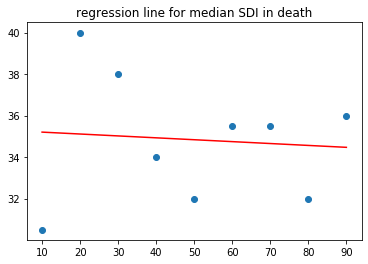

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.135
Method:                 Least Squares   F-statistic:                   0.04769
Date:                Sat, 25 Apr 2020   Prob (F-statistic):              0.833
Time:                        19:10:08   Log-Likelihood:                -22.251
No. Observations:                   9   AIC:                             48.50
Df Residuals:                       7   BIC:                             48.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2917      2.362     14.941      0.0

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [34]:
Y = df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('regression line for median SDI in death')
plt.show()
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

### SDI mean for new cases

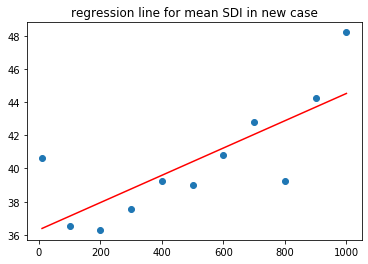

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     12.68
Date:                Sat, 25 Apr 2020   Prob (F-statistic):            0.00611
Time:                        19:11:34   Log-Likelihood:                -24.172
No. Observations:                  11   AIC:                             52.34
Df Residuals:                       9   BIC:                             53.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.3067      1.365     26.607      0.0

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [37]:
df_case = pd.DataFrame({ 'x' : case_x,
    'mean' : mean_case,'median': median_case})
X = df_case.iloc[:, 0].values.reshape(-1, 1)
Y = df_case.iloc[:, 1].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('regression line for mean SDI in new case')
plt.show()
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

### SDI median for new cases

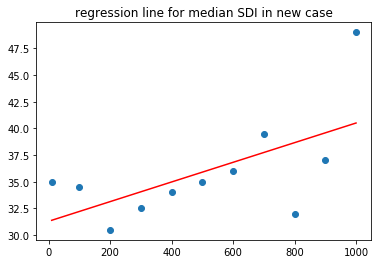

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5.321
Date:                Sat, 25 Apr 2020   Prob (F-statistic):             0.0465
Time:                        20:10:54   Log-Likelihood:                -30.209
No. Observations:                  11   AIC:                             64.42
Df Residuals:                       9   BIC:                             65.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2952      2.362     13.248      0.0

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [39]:
Y = df_case.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('regression line for median SDI in new case')
plt.show()
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())